In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-02 18:25:16.604361: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-02 18:25:29.866107: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-02 18:25:29.879622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-12-02 18:25:29.879665: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-02 18:25:29.882242: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-02 18:25:29.884922: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps) 
    
pre_data = data[..., -3:-2]
t_star = t_star[-2:]
data = data[..., -2:]
T = t_star.shape[0]    
    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size


In [6]:
pre_data.shape

(2, 100, 100, 1)

In [7]:
data.shape

(2, 100, 100, 2)

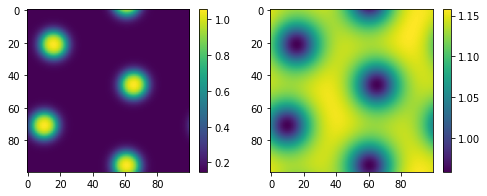

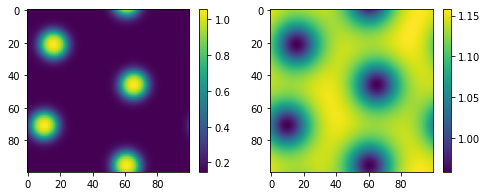

In [8]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

In [9]:
simulation.Ds

(0.01, 1.0)

In [10]:
dxdy = x_size*y_size/L**2
c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [11]:
c_t.shape

(2, 100, 100, 2)

In [12]:
c_yy.shape

(2, 100, 100, 2)

In [13]:
T

2

In [14]:
dxdy = x_size*y_size/L**2
diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [15]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
indices_sub = indices_all[:, 30:65, 50:85]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
                         #dataset['obs_output'][second_s]])

diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
                         #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])


obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
#pde_X = pde_X[:,:2]
obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [16]:
c_xx.shape

(2, 100, 100, 2)

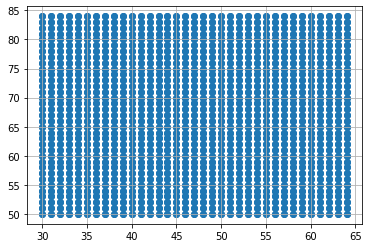

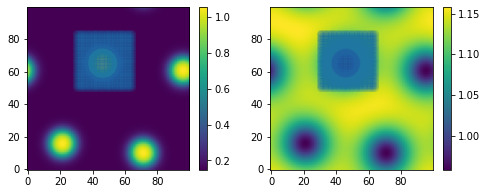

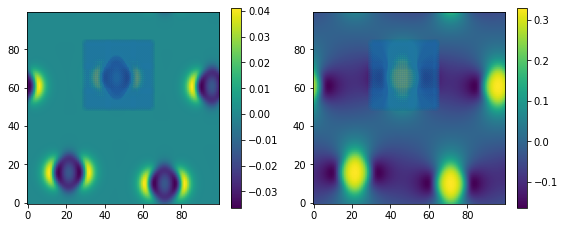

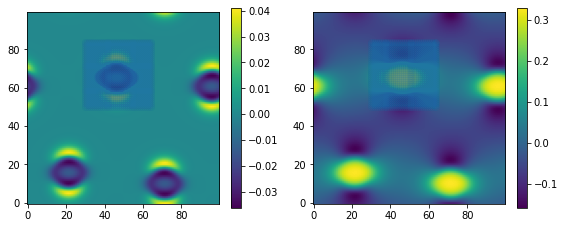

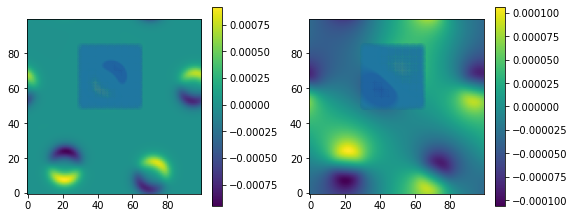

In [17]:
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (x_size-1)*obs_X[:,1]/simulation.L[1])
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_xx[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.subplot(122)
plt.imshow(c_xx[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_yy[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.subplot(122)
plt.imshow(c_yy[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_t[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.subplot(122)
plt.imshow(c_t[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/simulation.L[0], (y_size-1)*obs_X[:,1]/simulation.L[1], alpha=.05)
plt.tight_layout()
plt.show()

In [18]:
der_X.shape

(2450, 9)

In [19]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)
ds_obs = TINN_Dataset(tf.float32, obs_X)
ds_der = TINN_Dataset(tf.float32, der_X)
ds_obs_der = TINN_Dataset(tf.float32, obs_X, der_X)
ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)

In [20]:
ds.sizes

array([2450, 2450])

In [21]:
#layers = [3, 1024, 1024, 2]
#layers = [3, 512, 512, 512, 512, 2]
layers = [3, 128, 128, 128, 128, 128, 2]
#layers = [2, 32, 32, 32, 32, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                   # alpha_u = alpha_u,
                   # alpha_v = alpha_v,
                   regularise=True,
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
#obs_loss = Observation_Loss(regularise=True, input_dim=2)
obs_loss = Observation_Loss(regularise=True)
#pbc_loss = Periodic_Boundary_Condition(regularise=True)
#diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            #input_dim =2,
#                            dtype = pinnKM.dtype)
der_loss = Derivatives_Loss(dtype = pinnKM.dtype,
                            Ds = simulation.Ds,
                           )
obs_der_loss = Observation_And_Derivatives_Loss(dtype = pinnKM.dtype,
                            Ds = simulation.Ds,
                           )
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
#obs_X, pde_X)
modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [obs_loss],#, pde_resKM],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                  alpha = 0.9, 
                  print_precision=".12f")

In [115]:
2450/49

50.0

In [22]:
results_KM2 = modelKM.train(epochs = 1000+1,
                          batch_size = 245,
                          dataset = ds_obs_der,
                          print_interval=20,
                          stop_threshold = 1e-12,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0


2022-12-02 18:26:19.991159: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-02 18:26:20.626082: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


total loss: 14.582265198231, total regularised loss: 14.582264900208
Observation_Loss -> 
(1)  obs u: 0.194258277537 (2)  obs v: 1.263968266547 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 
Time taken: 2.68s

Start of epoch 20
total loss: 0.799094632268, total regularised loss: 1.004862427711
Observation_Loss -> 
(1)  obs u: 0.068420665106 (2)  obs v: 0.011488800752 
(1) lambdas : 1.408759117126 (2) lambdas : 0.591240644455 
Time taken: 1.86s

Start of epoch 40
total loss: 0.703212020919, total regularised loss: 1.281793355942
Observation_Loss -> 
(1)  obs u: 0.067459833808 (2)  obs v: 0.002861369969 
(1) lambdas : 1.904698729515 (2) lambdas : 0.095301017165 
Time taken: 1.58s

Start of epoch 60
total loss: 0.697266601026, total regularised loss: 1.329682469368
Observation_Loss -> 
(1)  obs u: 0.067197038792 (2)  obs v: 0.002529623525 
(1) lambdas : 1.979191780090 (2) lambdas : 0.020808286965 
Time taken: 1.58s

Start of epoch 80
total loss: 0.697464745492, total regulari


Start of epoch 700
total loss: 0.018815705902, total regularised loss: 0.028816582635
Observation_Loss -> 
(1)  obs u: 0.001559299742 (2)  obs v: 0.000322270887 
(1) lambdas : 1.806412339211 (2) lambdas : 0.193587481976 
Time taken: 1.63s

Start of epoch 720
total loss: 0.017584513524, total regularised loss: 0.026588434353
Observation_Loss -> 
(1)  obs u: 0.001433652749 (2)  obs v: 0.000324798646 
(1) lambdas : 1.812758445740 (2) lambdas : 0.187241464853 
Time taken: 1.47s

Start of epoch 740
total loss: 0.167512251996, total regularised loss: 0.301465988159
Observation_Loss -> 
(1)  obs u: 0.015967195617 (2)  obs v: 0.000784029493 
(1) lambdas : 1.891309618950 (2) lambdas : 0.108690321445 
Time taken: 1.51s

Start of epoch 760
total loss: 0.017409913940, total regularised loss: 0.025999374688
Observation_Loss -> 
(1)  obs u: 0.001397949853 (2)  obs v: 0.000343041580 
(1) lambdas : 1.809111475945 (2) lambdas : 0.190888449550 
Time taken: 1.51s

Start of epoch 780
total loss: 0.015496

In [33]:
results_KM3 = modelKM.train(epochs = 1000+1,
                          batch_size = 245,
                          dataset = ds_obs_der,
                          print_interval=20,
                          stop_threshold = 1e-12,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.009059989359, total regularised loss: 0.012931156904
Observation_Loss -> 
(1)  obs u: 0.000707019211 (2)  obs v: 0.000198979738 
(1) lambdas : 1.761981964111 (2) lambdas : 0.238017812371 
Time taken: 0.37s

Start of epoch 20
total loss: 0.030779096414, total regularised loss: 0.053482364863
Observation_Loss -> 
(1)  obs u: 0.002810345435 (2)  obs v: 0.000267564311 
(1) lambdas : 1.892926216125 (2) lambdas : 0.107073679566 
Time taken: 1.60s

Start of epoch 40
total loss: 0.010163866973, total regularised loss: 0.014495693147
Observation_Loss -> 
(1)  obs u: 0.000804899408 (2)  obs v: 0.000211487294 
(1) lambdas : 1.716906070709 (2) lambdas : 0.283093988895 
Time taken: 1.62s

Start of epoch 60
total loss: 0.007794078498, total regularised loss: 0.010433524847
Observation_Loss -> 
(1)  obs u: 0.000588443082 (2)  obs v: 0.000190964772 
(1) lambdas : 1.664776921272 (2) lambdas : 0.335223257542 
Time taken: 1.60s

Start of epoch 80
total loss: 0.008556329645


Start of epoch 700
total loss: 0.001344387907, total regularised loss: 0.001497017685
Observation_Loss -> 
(1)  obs u: 0.000083370721 (2)  obs v: 0.000051068070 
(1) lambdas : 1.471015095711 (2) lambdas : 0.528985023499 
Time taken: 1.46s

Start of epoch 720
total loss: 0.001184757231, total regularised loss: 0.001316990471
Observation_Loss -> 
(1)  obs u: 0.000074083161 (2)  obs v: 0.000044392563 
(1) lambdas : 1.444176197052 (2) lambdas : 0.555823922157 
Time taken: 1.50s

Start of epoch 740
total loss: 0.001058148802, total regularised loss: 0.001174981589
Observation_Loss -> 
(1)  obs u: 0.000066579206 (2)  obs v: 0.000039235674 
(1) lambdas : 1.426789045334 (2) lambdas : 0.573211371899 
Time taken: 1.65s

Start of epoch 760
total loss: 0.000953867253, total regularised loss: 0.001061021001
Observation_Loss -> 
(1)  obs u: 0.000060223454 (2)  obs v: 0.000035163273 
(1) lambdas : 1.428129315376 (2) lambdas : 0.571870625019 
Time taken: 1.61s

Start of epoch 780
total loss: 0.001033

In [44]:
modelKM.optimizer.lr.assign(8e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=8e-05>

In [45]:
results_KM4 = modelKM.train(epochs = 1000+1,
                          batch_size = 245,
                          dataset = ds_obs_der,
                          print_interval=20,
                          stop_threshold = 1e-12,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.000773735002, total regularised loss: 0.000827388605
Observation_Loss -> 
(1)  obs u: 0.000045163725 (2)  obs v: 0.000032209777 
(1) lambdas : 1.414186716080 (2) lambdas : 0.585813403130 
Time taken: 0.38s

Start of epoch 20
total loss: 0.000694838589, total regularised loss: 0.000745326455
Observation_Loss -> 
(1)  obs u: 0.000043046963 (2)  obs v: 0.000026436898 
(1) lambdas : 1.304087162018 (2) lambdas : 0.695912778378 
Time taken: 1.51s

Start of epoch 40
total loss: 0.000637480036, total regularised loss: 0.000700710283
Observation_Loss -> 
(1)  obs u: 0.000041223934 (2)  obs v: 0.000022524071 
(1) lambdas : 1.340999841690 (2) lambdas : 0.659000098705 
Time taken: 1.48s

Start of epoch 60
total loss: 0.000595674141, total regularised loss: 0.000674278301
Observation_Loss -> 
(1)  obs u: 0.000039471629 (2)  obs v: 0.000020095785 
(1) lambdas : 1.409367442131 (2) lambdas : 0.590632617474 
Time taken: 1.51s

Start of epoch 80
total loss: 0.000563317077


Start of epoch 700
total loss: 0.000258776103, total regularised loss: 0.000289052288
Observation_Loss -> 
(1)  obs u: 0.000015735653 (2)  obs v: 0.000010141958 
(1) lambdas : 1.542964339256 (2) lambdas : 0.457035511732 
Time taken: 1.62s

Start of epoch 720
total loss: 0.000251320467, total regularised loss: 0.000282233144
Observation_Loss -> 
(1)  obs u: 0.000015281095 (2)  obs v: 0.000009850951 
(1) lambdas : 1.570370197296 (2) lambdas : 0.429629743099 
Time taken: 1.61s

Start of epoch 740
total loss: 0.000244158360, total regularised loss: 0.000274744787
Observation_Loss -> 
(1)  obs u: 0.000014813922 (2)  obs v: 0.000009601915 
(1) lambdas : 1.587502837181 (2) lambdas : 0.412497133017 
Time taken: 1.53s

Start of epoch 760
total loss: 0.000260087083, total regularised loss: 0.000298162893
Observation_Loss -> 
(1)  obs u: 0.000016402872 (2)  obs v: 0.000009605837 
(1) lambdas : 1.546032428741 (2) lambdas : 0.453967511654 
Time taken: 1.53s

Start of epoch 780
total loss: 0.006873

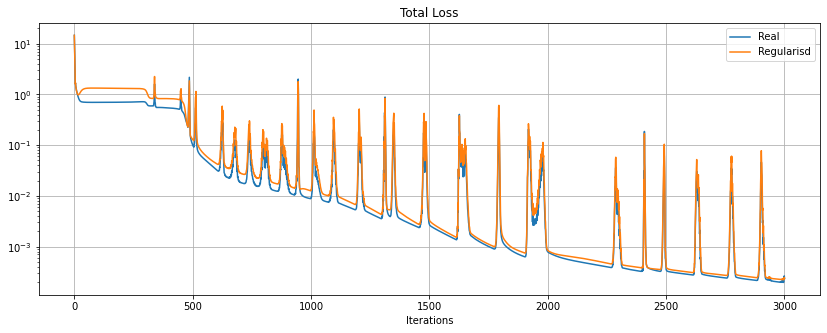

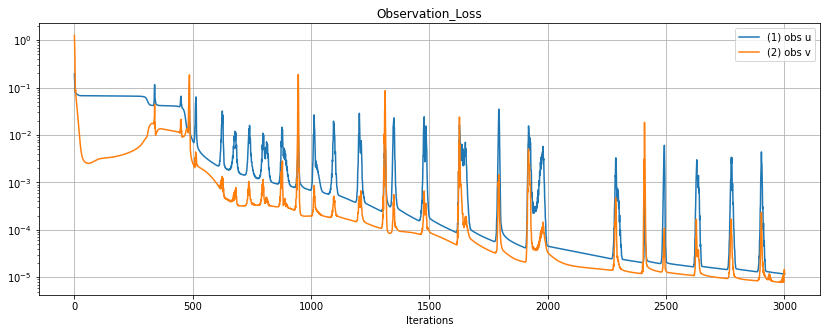

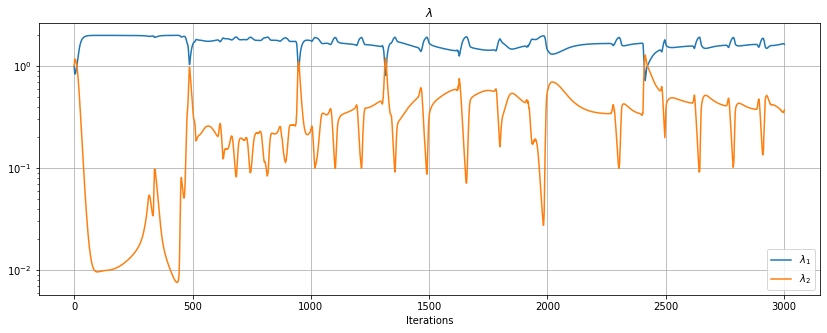

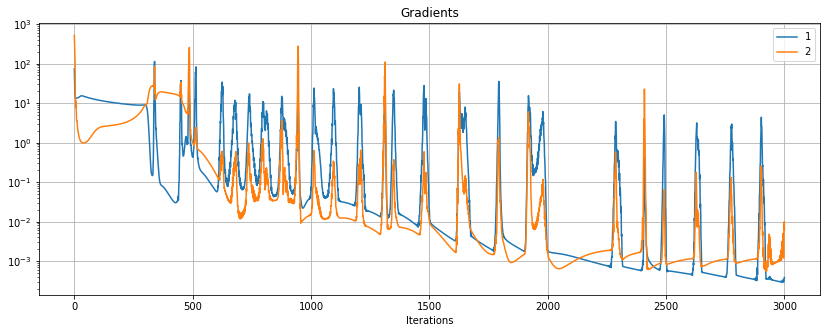

In [46]:
plot_result(merge_dict(results_KM2,results_KM3, results_KM4), modelKM, start=0)
            #,param_names=pde_resKM.parameter_names())

In [56]:
lb2 = np.min(obs_outputs, axis=0)
ub2 = np.max(obs_outputs, axis=0)

#layers2 = [2, 256, 256,  2]
#skips =   [2, 0,   0,   1]
#layers2 = [2, 256, 256, 256, 2]
#skips =   [0, 2,   0, 1,   0]

layers2 = [2, 256, 256, 2]
skips =   [0, 0,   0,  1]

pinn2 = NN_Compound(pinnKM,lb2, ub2, lb, ub,layers2, skips, dtype=tf.float32)


In [57]:
modelKM2 = tu.TINN(pinn2, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [obs_loss, der_loss],#, pde_resKM],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                  alpha = 0.9, 
                  print_precision=".12f")

In [ ]:
results_KM2_1 = modelKM2.train(epochs = 1000+1,
                          batch_size = 245,
                          dataset = ds_obs_der,
                          print_interval=20,
                          stop_threshold = 1e-12,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
 to layer3
total loss: 1.508239109069, total regularised loss: 1.508239150047
Observation_Loss -> 
(1)  obs u: 0.009297423181 (2)  obs v: 0.003422163765 
Derivatives_Loss -> 
(1)  u_xx: 0.000491172376 (2)  u_yy: 0.000631585406 (3)  u_t: 0.000170621909 
(4)  v_xx: 0.064852720010 (5)  v_yy: 0.071937112021 (6)  v_t: 0.000021112227 

(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
Time taken: 39.02s

Start of epoch 20
total loss: 0.363047929481, total regularised loss: 1.059362411499
Observation_Loss -> 
(1)  obs u: 0.000017126811 (2)  obs v: 0.001633532745 
Derivatives_Loss -> 
(1)  u_xx: 0.000376173641 (2)  u_yy: 0.000486578939 (3)  u_t: 0.000081011403 
(4)  v_xx: 0.014684239082 (5)  v_yy: 0.019025912101 (6)  v_t: 0.000000219368 

(1) lambdas : 0.123453639448 (2) lambdas : 0.27459293603


Start of epoch 280
total loss: 0.368310200050, total regularised loss: 1.203275084496
Observation_Loss -> 
(1)  obs u: 0.000621901369 (2)  obs v: 0.001704255796 
Derivatives_Loss -> 
(1)  u_xx: 0.000301783368 (2)  u_yy: 0.000403534865 (3)  u_t: 0.000104076170 
(4)  v_xx: 0.015114844486 (5)  v_yy: 0.018580442877 (6)  v_t: 0.000000182247 

(1) lambdas : 0.047402892262 (2) lambdas : 0.169668480754 (3) lambdas : 0.392194986343 
(4) lambdas : 0.488248586655 (5) lambdas : 0.044514846057 (6) lambdas : 1.985127329826 
(7) lambdas : 4.872834682465 (8) lambdas : 0.000007482536 
Time taken: 7.41s

Start of epoch 300
total loss: 0.368656845763, total regularised loss: 1.205758810043
Observation_Loss -> 
(1)  obs u: 0.000623167052 (2)  obs v: 0.001705730967 
Derivatives_Loss -> 
(1)  u_xx: 0.000301733712 (2)  u_yy: 0.000403471580 (3)  u_t: 0.000104109935 
(4)  v_xx: 0.015132839617 (5)  v_yy: 0.018594447960 (6)  v_t: 0.000000184172 

(1) lambdas : 0.047123987228 (2) lambdas : 0.168955430388 (3) lam


Start of epoch 560
total loss: 0.371714634821, total regularised loss: 1.250590324402
Observation_Loss -> 
(1)  obs u: 0.000637739275 (2)  obs v: 0.001776367120 
Derivatives_Loss -> 
(1)  u_xx: 0.000301101622 (2)  u_yy: 0.000402702556 (3)  u_t: 0.000104620497 
(4)  v_xx: 0.015520169982 (5)  v_yy: 0.018428613927 (6)  v_t: 0.000000148789 

(1) lambdas : 0.038158606738 (2) lambdas : 0.140244334936 (3) lambdas : 0.320178985596 
(4) lambdas : 0.398515850306 (5) lambdas : 0.035481289029 (6) lambdas : 1.752927899361 
(7) lambdas : 5.314489841461 (8) lambdas : 0.000003631594 
Time taken: 6.21s


In [ ]:
'sigma_u': 0.1, 'sigma_v': 0.1, 'mu_u': 1.0, 'rho_u': 1.95, 
'rho_v': 1.5, 'kappa_u': 1.0

In [37]:
print(pde_resKM.trainables_str())

sigma_u: 0.16210 sigma_v: 0.07117 rho_u: 1.00643 rho_v: 1.18084 



In [38]:
def norm_params(pde_resKM, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = (pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u).numpy()
    sigma_v = (pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v).numpy()
    mu_u = (pde_resKM.mu_u.get_value(test_d)).numpy()
    rho_u = (pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v).numpy()
    rho_v = (pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    kappa_u = (pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + (sigma_v-sigma_v2)**2 +(mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + (rho_v-rho_v2)**2 +(kappa_u-kappa_u2)**2
           )
    
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = result["sigma_u"] if "sigma_u" in result.keys() else simulation.parameters["sigma_u"]
    sigma_v =  result["sigma_v"] if "sigma_v" in result.keys() else simulation.parameters["sigma_v"]
    mu_u = result["mu_u"] if "mu_u" in result.keys() else simulation.parameters["mu_u"]
    rho_u = result["rho_u"] if "rho_u" in result.keys() else simulation.parameters["rho_u"]
    rho_v = result["rho_v"] if "rho_v" in result.keys() else simulation.parameters["rho_v"]
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else simulation.parameters["kappa_u"]
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + 
            (sigma_v-sigma_v2)**2 +
            (mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )
        

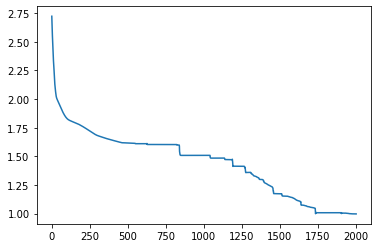

In [39]:
plt.plot(norm_params2(merge_dict(results_KM, results_KM2)#, results_KM3, results_KM4) 
                      ,simulation))

# Second test: No fixed parameter but more data for training

In [26]:
print(pde_resKM.trainables_str())

sigma_u: 0.38628 sigma_v: 0.46425 rho_u: 0.72278 rho_v: 1.29516 



In [ ]:
'sigma_u': 0.1, 'sigma_v': 0.1, 'mu_u': 1.0, 'rho_u': 1.95, 
'rho_v': 1.5, 'kappa_u': 1.0

In [47]:
@tf.function
def derivatives(pinn, x):
    #return pde_resKM.derivatives(pinn, x)
    return obs_loss.derivatives(pinn, x)

In [48]:
test_d = obs_X[:,:3].astype(np.float32)

In [49]:
y, u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t = derivatives(pinnKM, test_d)
D_u = pde_resKM.D_u.get_value(test_d)
D_v = pde_resKM.D_v.get_value(test_d)
sigma_u = pde_resKM.sigma_u.get_value(test_d) #/ pde_resKM.alpha_u
sigma_v = pde_resKM.sigma_v.get_value(test_d) #/ pde_resKM.alpha_v
mu_u = pde_resKM.mu_u.get_value(test_d)
rho_u = pde_resKM.rho_u.get_value(test_d) ##* pde_resKM.alpha_u * pde_resKM.alpha_v
rho_v = pde_resKM.rho_v.get_value(test_d) #* pde_resKM.alpha_u * pde_resKM.alpha_u
kappa_u = pde_resKM.kappa_u.get_value(test_d) #* pde_resKM.alpha_u * pde_resKM.alpha_u
#A = kappa_u = pde_resKM.A.get_value(test_d) 
#B = kappa_u = pde_resKM.B.get_value(test_d) 

In [50]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())

[0.00037935696, 0.066627525]
[0.00037936 0.06662753]


In [51]:
diffusion_u = D_u * (u_xx + u_yy)
diffusion_v = D_v * (v_xx + v_yy)

dxdy = x_size * y_size/ L**2
#diffusion_u_space = D_u * dxdy * diffusion([x_size, y_size], u.numpy().reshape(x_size, y_size))
#diffusion_v_space = D_v * dxdy * diffusion([x_size, y_size], v.numpy().reshape(x_size, y_size))


f = u * u * v / (1.0 + kappa_u * u * u)
non_lin_u = -rho_u * f
non_lin_v = rho_v * f
f_u = - rho_u * f + mu_u * u - sigma_u
f_v = rho_v * f - sigma_v


f_real = u * u * v / (1.0 + simulation.parameters["kappa_u"] * u * u)
f_u_real = - simulation.parameters["rho_u"] * f_real + simulation.parameters["mu_u"] * u - simulation.parameters["sigma_u"]
f_v_real = simulation.parameters["rho_v"] * f_real - simulation.parameters["sigma_v"]

d_t_u = - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u
d_t_v = -D_v * (v_xx + v_yy) + rho_v * f - sigma_v


#diff_Y = np.array([[dxdy * [0.005, 0.2][c] *diffusion((x_size,y_size), data[c, ..., t]) 
#                    for t in range(data.shape[3])]
#                    for c in range(data.shape[0])
#                   ])
#diff_Y = np.einsum("ctij -> cijt", diff_Y)
#u2v = u * u * v

#non_lin_u = -u2v
#non_lin_v = u2v
#f_u = - A + (B + 1) * u - u2v
#f_v = - B * u + u2v
#d_t_u = - D_u * (u_xx + u_yy) + f_u
#d_t_v = - D_v * (v_xx + v_yy) + f_v

In [52]:
block_size

1225

In [53]:
u.numpy().shape

(2450,)

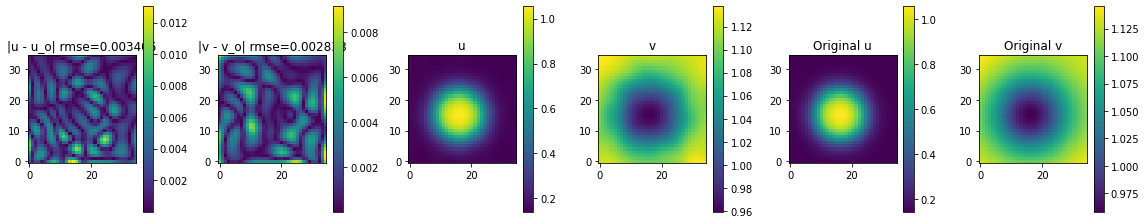

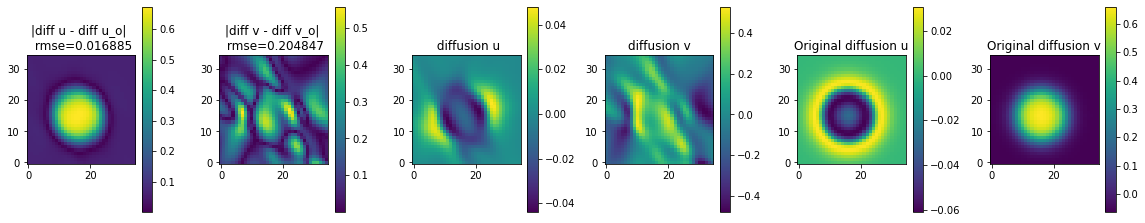

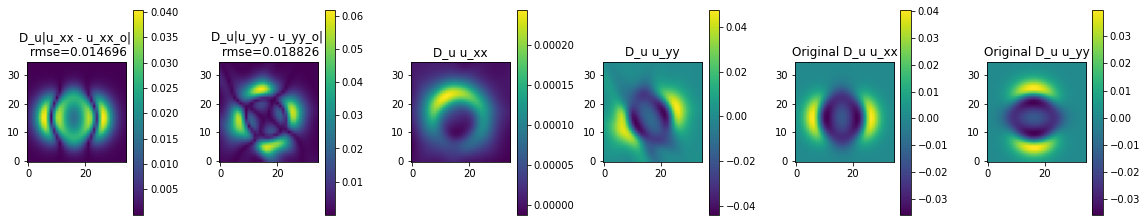

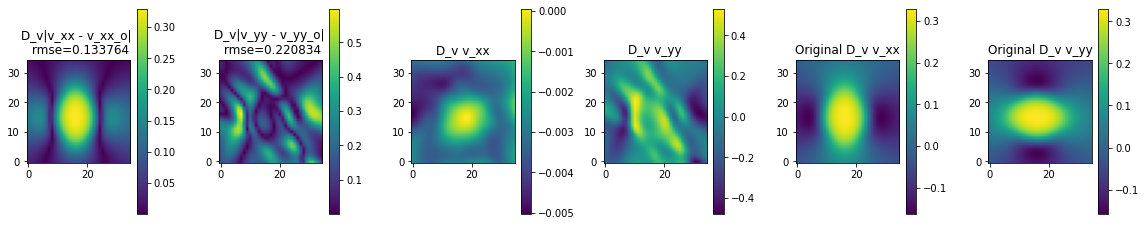

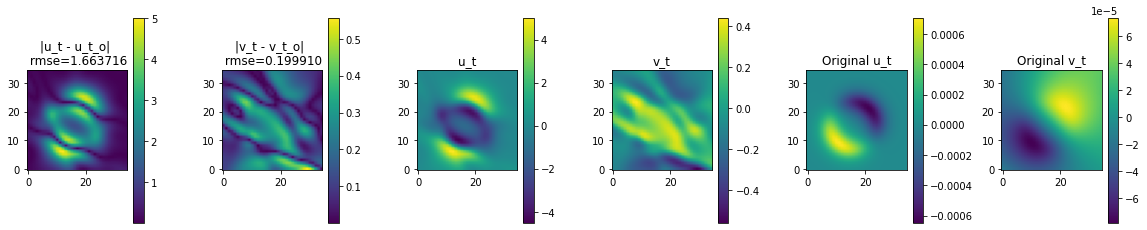

In [54]:
_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((u.numpy()[block_size:] - obs_X[block_size:,3])**2))
plt.title(f"|u - u_o| rmse={rmse:.6f}")
plt.imshow((np.abs(u.numpy()[block_size:] - obs_X[block_size:,3])).reshape(block_x, block_y).T,
          origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((v.numpy()[block_size:] - obs_X[block_size:,4])**2))
plt.title(f"|v - v_o| rmse={rmse:.6f}")
plt.imshow((np.abs(v.numpy()[block_size:] - obs_X[block_size:,4])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(163)
plt.title("u")
plt.imshow(u.numpy()[block_size:].reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("v")
plt.imshow(v.numpy()[block_size:].reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original u")
plt.imshow(obs_X[block_size:,3].reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original v")
plt.imshow(obs_X[block_size:,4].reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((diffusion_u.numpy()[block_size:]-diff_outputs[block_size:,0])**2))
plt.title(f"|diff u - diff u_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(diffusion_u.numpy()[block_size:]-diff_outputs[block_size:,1])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((diffusion_v.numpy()[block_size:]-diff_outputs[block_size:,1])**2))
plt.title(f"|diff v - diff v_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(diffusion_v.numpy()[block_size:]-diff_outputs[block_size:,1])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)            
plt.subplot(163)
plt.title(" diffusion u")
plt.imshow((diffusion_u.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("diffusion v")
plt.imshow((diffusion_v.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original diffusion u")
plt.imshow((diff_outputs[block_size:,0]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original diffusion v")
plt.imshow((diff_outputs[block_size:,1]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()


_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((D_u*u_xx.numpy()[block_size:]-der_u_outputs[block_size:,0])**2))
plt.title(f"D_u|u_xx - u_xx_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(D_u*u_xx.numpy()[block_size:]-der_u_outputs[block_size:,0])).reshape(block_x, block_y).T, 
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((D_u*u_yy.numpy()[block_size:]-der_u_outputs[block_size:,1])**2))
plt.title(f"D_u|u_yy - u_yy_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(D_u*u_yy.numpy()[block_size:]-der_u_outputs[block_size:,1])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)            
plt.subplot(163)
plt.title("D_u u_xx")
plt.imshow(D_u*(u_xx.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("D_u u_yy")
plt.imshow(D_u*(u_yy.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original D_u u_xx")
plt.imshow((der_u_outputs[block_size:,0]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original D_u u_yy")
plt.imshow((der_u_outputs[block_size:,1]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((D_v*v_xx.numpy()[block_size:]-der_v_outputs[block_size:,0])**2))
plt.title(f"D_v|v_xx - v_xx_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(D_v*v_xx.numpy()[block_size:]-der_v_outputs[block_size:,0])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((D_v*v_yy.numpy()[block_size:]-der_v_outputs[block_size:,1])**2))
plt.title(f"D_v|v_yy - v_yy_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(D_v*v_yy.numpy()[block_size:]-der_v_outputs[block_size:,1])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)            
plt.subplot(163)
plt.title("D_v v_xx")
plt.imshow(D_v*(v_xx.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("D_v v_yy")
plt.imshow(D_v*(v_yy.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original D_v v_xx")
plt.imshow((der_v_outputs[block_size:,0]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original D_v v_yy")
plt.imshow((der_v_outputs[block_size:,1]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((u_t.numpy()[block_size:]-der_u_outputs[block_size:,2])**2))
plt.title(f"|u_t - u_t_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(u_t.numpy()[block_size:]-der_u_outputs[block_size:,2])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((v_t.numpy()[block_size:]-der_v_outputs[block_size:,2])**2))
plt.title(f"|v_t - v_t_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(v_t.numpy()[block_size:]-der_v_outputs[block_size:,2])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)            
plt.subplot(163)
plt.title("u_t")
plt.imshow((u_t.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("v_t")
plt.imshow((v_t.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original u_t")
plt.imshow((der_u_outputs[block_size:,2]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original v_t")
plt.imshow((der_v_outputs[block_size:,2]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

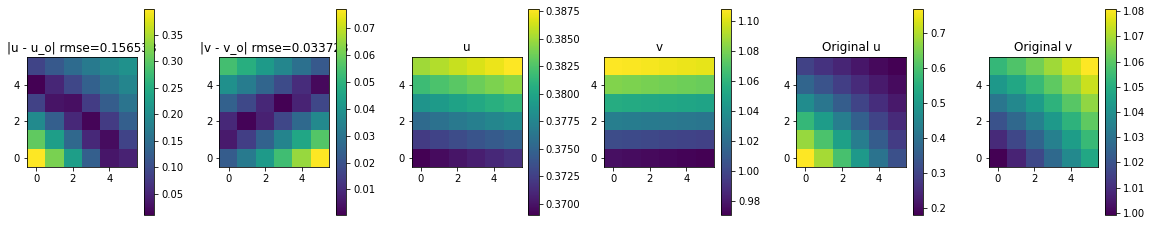

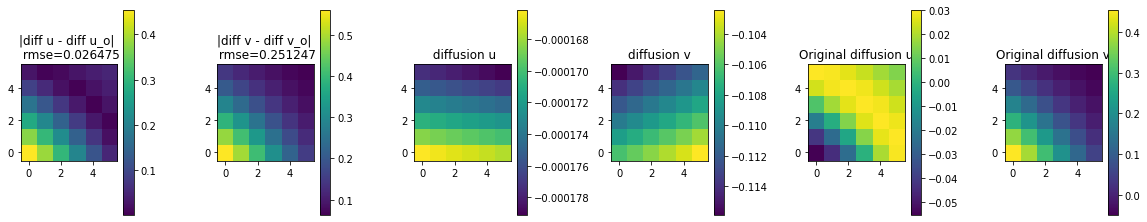

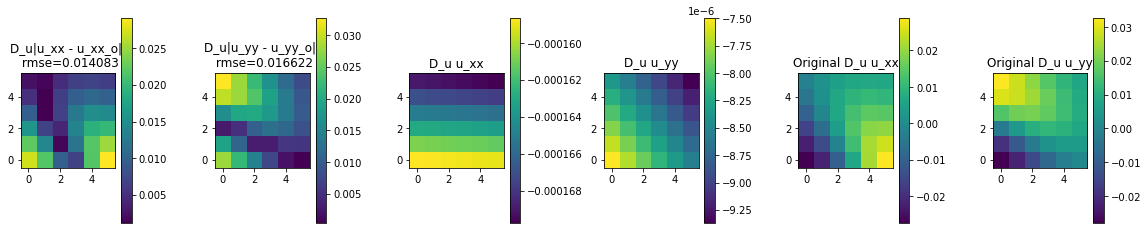

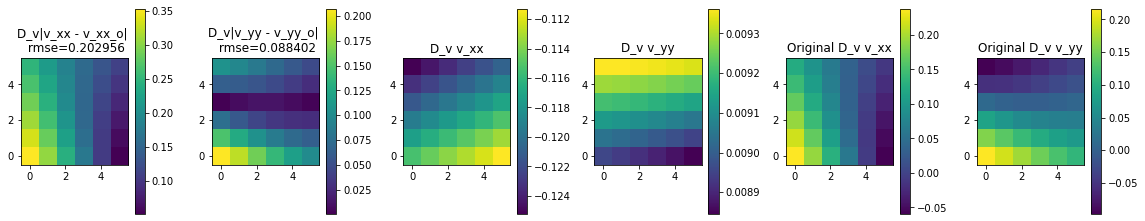

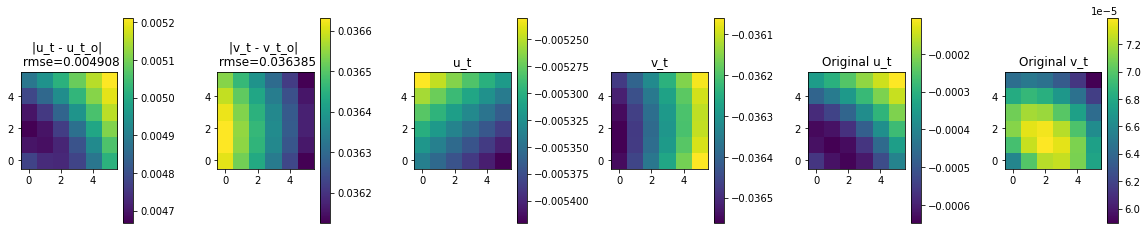

In [35]:
_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((u.numpy()[block_size:] - obs_X[block_size:,3])**2))
plt.title(f"|u - u_o| rmse={rmse:.6f}")
plt.imshow((np.abs(u.numpy()[block_size:] - obs_X[block_size:,3])).reshape(block_x, block_y).T,
          origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((v.numpy()[block_size:] - obs_X[block_size:,4])**2))
plt.title(f"|v - v_o| rmse={rmse:.6f}")
plt.imshow((np.abs(v.numpy()[block_size:] - obs_X[block_size:,4])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(163)
plt.title("u")
plt.imshow(u.numpy()[block_size:].reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("v")
plt.imshow(v.numpy()[block_size:].reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original u")
plt.imshow(obs_X[block_size:,3].reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original v")
plt.imshow(obs_X[block_size:,4].reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((diffusion_u.numpy()[block_size:]-diff_outputs[block_size:,0])**2))
plt.title(f"|diff u - diff u_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(diffusion_u.numpy()[block_size:]-diff_outputs[block_size:,1])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((diffusion_v.numpy()[block_size:]-diff_outputs[block_size:,1])**2))
plt.title(f"|diff v - diff v_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(diffusion_v.numpy()[block_size:]-diff_outputs[block_size:,1])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)            
plt.subplot(163)
plt.title(" diffusion u")
plt.imshow((diffusion_u.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("diffusion v")
plt.imshow((diffusion_v.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original diffusion u")
plt.imshow((diff_outputs[block_size:,0]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original diffusion v")
plt.imshow((diff_outputs[block_size:,1]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()


_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((D_u*u_xx.numpy()[block_size:]-der_u_outputs[block_size:,0])**2))
plt.title(f"D_u|u_xx - u_xx_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(D_u*u_xx.numpy()[block_size:]-der_u_outputs[block_size:,0])).reshape(block_x, block_y).T, 
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((D_u*u_yy.numpy()[block_size:]-der_u_outputs[block_size:,1])**2))
plt.title(f"D_u|u_yy - u_yy_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(D_u*u_yy.numpy()[block_size:]-der_u_outputs[block_size:,1])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)            
plt.subplot(163)
plt.title("D_u u_xx")
plt.imshow(D_u*(u_xx.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("D_u u_yy")
plt.imshow(D_u*(u_yy.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original D_u u_xx")
plt.imshow((der_u_outputs[block_size:,0]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original D_u u_yy")
plt.imshow((der_u_outputs[block_size:,1]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((D_v*v_xx.numpy()[block_size:]-der_v_outputs[block_size:,0])**2))
plt.title(f"D_v|v_xx - v_xx_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(D_v*v_xx.numpy()[block_size:]-der_v_outputs[block_size:,0])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((D_v*v_yy.numpy()[block_size:]-der_v_outputs[block_size:,1])**2))
plt.title(f"D_v|v_yy - v_yy_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(D_v*v_yy.numpy()[block_size:]-der_v_outputs[block_size:,1])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)            
plt.subplot(163)
plt.title("D_v v_xx")
plt.imshow(D_v*(v_xx.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("D_v v_yy")
plt.imshow(D_v*(v_yy.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original D_v v_xx")
plt.imshow((der_v_outputs[block_size:,0]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original D_v v_yy")
plt.imshow((der_v_outputs[block_size:,1]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(161)
rmse = np.sqrt(np.mean((u_t.numpy()[block_size:]-der_u_outputs[block_size:,2])**2))
plt.title(f"|u_t - u_t_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(u_t.numpy()[block_size:]-der_u_outputs[block_size:,2])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(162)
rmse = np.sqrt(np.mean((v_t.numpy()[block_size:]-der_v_outputs[block_size:,2])**2))
plt.title(f"|v_t - v_t_o| \n rmse={rmse:.6f}")
plt.imshow((np.abs(v_t.numpy()[block_size:]-der_v_outputs[block_size:,2])).reshape(block_x, block_y).T,
           origin='lower')
plt.colorbar(shrink=.5)            
plt.subplot(163)
plt.title("u_t")
plt.imshow((u_t.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(164)
plt.title("v_t")
plt.imshow((v_t.numpy()[block_size:]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(165)
plt.title("Original u_t")
plt.imshow((der_u_outputs[block_size:,2]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.subplot(166)
plt.title("Original v_t")
plt.imshow((der_v_outputs[block_size:,2]).reshape(block_x, block_y).T, origin='lower')
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

In [111]:
block_x*block_y

900

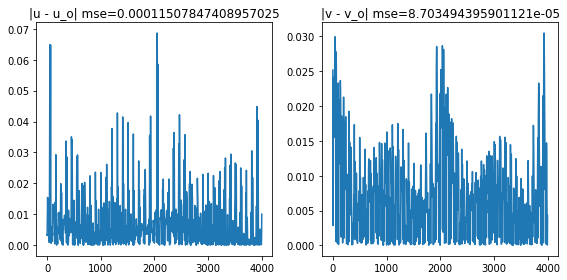

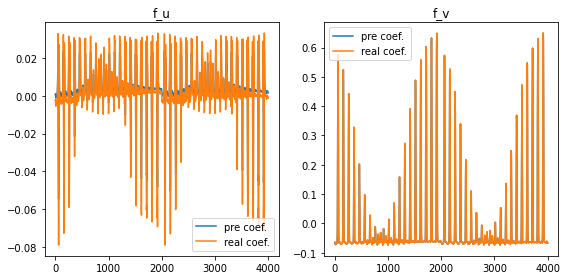

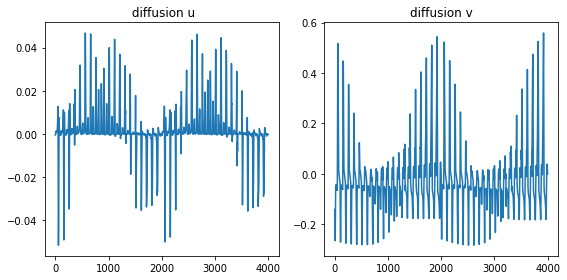

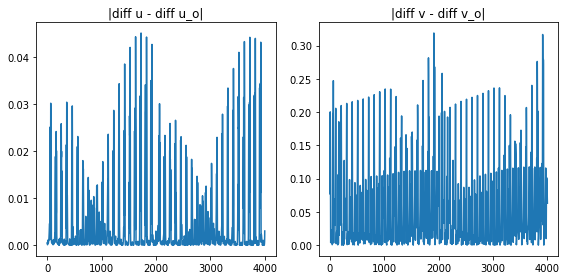

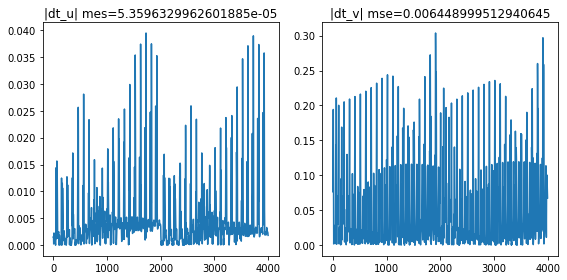

In [266]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
mse = np.mean((u.numpy() - obs_X[:,3])**2)
plt.title(f"|u - u_o| mse={mse}")
plt.plot(np.abs(u.numpy() - obs_X[:,3]))
plt.subplot(122)
mse = np.mean((v.numpy() - obs_X[:,4])**2)
plt.title(f"|v - v_o| mse={mse}")
plt.plot(np.abs(v.numpy() - obs_X[:,4]))
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("f_u")
plt.plot(f_u.numpy(), label="pre coef.")
plt.plot(f_u_real.numpy(), label="real coef.")
plt.legend()
plt.subplot(122)
plt.title("f_v")
plt.plot(f_v.numpy(), label="pre coef.")
plt.plot(f_v_real.numpy(), label="real coef.")
plt.legend()
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title(" diffusion u")
plt.plot(diffusion_u.numpy())
plt.subplot(122)
plt.title("diffusion v")
plt.plot(diffusion_v.numpy())
plt.tight_layout()
plt.show()


_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("|diff u - diff u_o|")
plt.plot(np.abs(diffusion_u.numpy()-diff_outputs[:,0]))# diff_outputs[:,0]))#dataset['diff_output'][:,0]))
plt.subplot(122)
plt.title("|diff v - diff v_o|")
plt.plot(np.abs(diffusion_v.numpy()-diff_outputs[:,1]))# diff_outputs[:,1]))#- dataset['diff_output'][:,1]))
plt.tight_layout()
plt.show()



_ = plt.figure(figsize=(8,4))
plt.subplot(121)
mse = np.mean(d_t_u.numpy()**2)
plt.title(f"|dt_u| mes={mse}")
plt.plot(np.abs(d_t_u.numpy()))
plt.subplot(122)
mse = np.mean(d_t_v.numpy()**2)
plt.title(f"|dt_v| mse={mse}")
plt.plot(np.abs(d_t_v.numpy()))
plt.tight_layout()
plt.show()



In [32]:
from scipy.optimize import lsq_linear

In [272]:
n = ds.sizes[0]
#b = np.r_[(simulation.Ds[0]*(u_xx + u_yy)).numpy() - u_t.numpy(), 
#          (simulation.Ds[1]*(v_xx + v_yy)).numpy()  - v_t.numpy()]
b =(-simulation.Ds[0]*(u_xx + u_yy)).numpy() - u_t.numpy()
#b =(-simulation.Ds[1]*(v_xx + v_yy)).numpy() - v_t.numpy()

#A = np.vstack((np.c_[f.numpy(), -u.numpy(), [1]*n, [0]*n, [0]*n],
#               np.c_[[0]*n, [0]*n, [0]*n, -f.numpy(), [1]*n]))
A = np.c_[f.numpy(), -u.numpy(), [1]*n]
#A = np.c_[-f.numpy(), [1]*n]


In [273]:
res = lsq_linear(A, b, bounds=(0, np.inf), lsq_solver='lsmr',verbose=1, tol=1e-20, 
                 max_iter=10000,
                 lsmr_tol='auto')#, method='bvls')
res

The unconstrained solution is optimal.
Final cost 1.1161e+03, first-order optimality 3.35e+00


 active_mask: array([0., 0., 0.])
        cost: 1116.1088624035378
         fun: array([-0.11199911, -0.10102441, -0.08945677, ..., -0.12335479,
       -0.12237777, -0.12127045])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 3.3535387783725428
      status: 3
     success: True
           x: array([14.8925665 ,  5.78066316,  0.38893646])

In [284]:
1.31779/.644

2.0462577639751554

In [278]:
pde_resKM.trainables_str()

'sigma_u: 0.06440 mu_u: 0.67079 rho_u: 1.31779 '

In [ ]:
'rho_u': 1.95, 'mu_u': 1.0, 'sigma_u': 0.1 
'rho_v': 1.5, 'sigma_v': 0.1,
'kappa_u': 1.0

In [269]:
params = np.array([simulation.parameters['rho_u'], simulation.parameters['mu_u'], 
                   simulation.parameters['sigma_u'],
                   simulation.parameters['rho_v'], simulation.parameters['sigma_v']])

In [270]:
np.mean(((np.dot(A, params)+b))**2)

0.3856713155410894

In [271]:
np.mean(((np.dot(A, res.x)+b))**2)

0.6809981093624486

In [157]:
obs_X.shape

(2000, 5)

In [208]:
n = simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
u_obs = obs_X[:, 3]# data[0, ..., -1].flatten()
v_obs = obs_X[:, 4]# data[1, ..., -1].flatten()
uxxyy_obs =simulation.Ds[0] * (n/l) * diffusion(simulation.n, obs_X[1000:, 3].reshape((20, y_size))).flatten()#diffusion(simulation.n, data[0, ..., -1]).flatten()
vxxyy_obs =simulation.Ds[1] * (n/l) * diffusion(simulation.n, obs_X[1000:, 4].reshape((20, y_size))).flatten()#diffusion(simulation.n, data[1, ..., -1]).flatten()
u_dt = obs_X[1000:, 3] - obs_X[:1000, 3]#(data[0, ..., -2] - data[0, ..., -1]).flatten()
v_dt = obs_X[1000:, 4] - obs_X[:1000, 4]#(data[1, ..., -2] - data[1, ..., -1]).flatten()

IndexError: index 99 is out of bounds for axis 0 with size 20

In [128]:
f_obs = u_obs * u_obs * v_obs / (1.0 + simulation.parameters['kappa_u'] * u_obs * u_obs)
A_obs = np.vstack((np.c_[f_obs, -u_obs, [1]*n, [0]*n, [0]*n],
                   np.c_[[0]*n, [0]*n, [0]*n, -f_obs, [1]*n]))
b_obs = np.r_[(uxxyy_obs-u_dt, vxxyy_obs-v_dt)]
params = np.array([simulation.parameters['rho_u'], simulation.parameters['mu_u'], 
                   simulation.parameters['sigma_u'],
                   simulation.parameters['rho_v'], simulation.parameters['sigma_v']])

In [129]:
np.mean(((np.dot(A_obs[10000:], params)+b_obs[10000:]))**2)

5.519419913191904e-09

In [130]:
np.mean(((np.dot(A_obs[:10000], params)+b_obs[:10000]))**2)

1.260036058560922e-07

In [55]:
class NN_Compound(tu.NN):
    def __init__(self, pre_pinn, lb, ub, pre_lb, pre_ub, layers, skips=None, dtype=tf.float32, **kwargs):
        assert pre_pinn.layers[-1] == layers[0]
        if skips is not None:
            assert len(skips) == len(layers)
        self.pre_Ws = [w.numpy() for w in pre_pinn.Ws]
        self.pre_bs = [b.numpy() for b in pre_pinn.bs]
        self.pre_lb = pre_lb
        self.pre_ub = pre_ub
        self.skips = skips       
        self.swtich_index = -1
        super().__init__(layers, lb, ub, dtype, **kwargs)
        self.lb = tf.expand_dims(tf.Variable(self.lb, dtype=dtype), axis=0)
        self.ub = tf.expand_dims(tf.Variable(self.ub, dtype=dtype), axis=0)
        self.__version__ = 0.1
        
        
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        biases = []
        for pre_W, pre_b in zip(self.pre_Ws, self.pre_bs):
            W = tf.Variable(pre_W, 
                            trainable=False,
                            dtype=self.dtype)
            b = tf.Variable(pre_b, 
                            trainable=False,
                            dtype=self.dtype)
            weights.append(W)
            biases.append(b)
            self.swtich_index += 1
            
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)

        self.Ws = weights
        self.bs = biases
            
    @tf.function
    def net(self, inputs):
        #inputs_2 = self.pre_pinn(inputs)
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.pre_lb) / (self.pre_ub - self.pre_lb) - 1.0
        for i, (W, b) in enumerate(zip(self.Ws[:-1], self.bs[:-1])):
            if i == self.swtich_index:
                H = tf.add(tf.matmul(H, W), b)
                H_skip = H
                H = 2.0 * (H - self.lb) / (self.ub - self.lb) - 1.0
            else:
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
                
            if i > self.swtich_index and  self.skips[i - self.swtich_index] == 1:
                H += H_skip
                H_skip = H
                print(f" to layer{i- self.swtich_index}")
                
            if i > self.swtich_index and  self.skips[i - self.swtich_index] == 2:
                print(f" from layer{i- self.swtich_index}")
                H_skip = H                    

        W = self.Ws[-1]
        b = self.bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        if self.skips[-1] == 1:
            outputs += H_skip
            print(f" to layer{len(self.skips)-1}")
        return outputs

        
    